<a href="https://colab.research.google.com/github/ahmedsghaier/Predict-mos-from-user-behavior-metrics/blob/main/pfa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calculer un MOS estimé (Mean Opinion Score) à partir de trois métriques : la durée moyenne des visites, le taux de rebond et le nombre de pages par visite.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm

file_path = "full_data.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.columns)

required_columns = ["Avg. Visit Duration", "Bounce Rate", "Pages / Visit"]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    raise ValueError(f"Colonnes manquantes dans le CSV : {missing_columns}")

# Remplacer les valeurs manquantes ou incorrectes par "00:00:00"
df["Avg. Visit Duration"] = df["Avg. Visit Duration"].replace(["--", None, "nan"], "00:00:00")

# Fonction de conversion de la durée en secondes
def convert_duration_to_seconds(duration):
    try:
        h, m, s = map(int, duration.split(':'))
        return h * 3600 + m * 60 + s
    except ValueError:
        return 0

# Appliquer la conversion pour la durée
df["Avg. Visit Duration (s)"] = df["Avg. Visit Duration"].apply(convert_duration_to_seconds)

# Conversion du taux de rebond en pourcentage
df["Bounce Rate (%)"] = pd.to_numeric(df["Bounce Rate"].str.rstrip('%'), errors='coerce')

# Remplir les valeurs manquantes de Bounce Rate avec la moyenne
df["Bounce Rate (%)"] = df["Bounce Rate (%)"].fillna(df["Bounce Rate (%)"].mean())

# Fonction de normalisation des données
def normalize_data(df):
    """Normaliser les colonnes numériques dans la plage [0,1]."""
    print("\nNormalizing numerical features...")

    numerical_cols = ['Avg. Visit Duration (s)', 'Pages / Visit', 'Bounce Rate (%)', 'Rank Change']

    # Normaliser les colonnes numériques
    for col in numerical_cols:
        # Convertir la colonne en numérique, en gérant les erreurs
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Remplacer les valeurs manquantes par la moyenne de la colonne
        df[col] = df[col].fillna(df[col].mean())

        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = (df[col] - min_val) / (max_val - min_val)
        print(f"Normalized {col}: Min={min_val:.2f}, Max={max_val:.2f}")

# Appliquer la normalisation
normalize_data(df)

# Fonction de calcul du MOS (Mean Opinion Score)
def calculate_mos(df, duration_weight=0.4, pages_weight=0.3, bounce_weight=0.3):
    """
    Calculer le MOS en utilisant des métriques pondérées.
    Assure une distribution sur la gamme complète de 1 à 5.
    """
    print(f"\nCalculating MOS with weights: Duration={duration_weight}, Pages={pages_weight}, Bounce={bounce_weight}")

    # Utiliser les valeurs d'origine pour une meilleure distribution
    duration = np.log1p(df['Avg. Visit Duration (s)'])  # Log transform to reduce outliers
    duration_score = (duration - duration.min()) / (duration.max() - duration.min())

    pages = np.log1p(df['Pages / Visit'])  # Log transform for pages per visit
    pages_score = (pages - pages.min()) / (pages.max() - pages.min())

    bounce_score = 1 - df['Bounce Rate (%)']  # Inverser le taux de rebond (plus bas est meilleur)

    # Calculer le score pondéré
    weighted_score = (
        duration_weight * duration_score +
        pages_weight * pages_score +
        bounce_weight * bounce_score
    )

    # Appliquer un classement basé sur le percentile pour une meilleure distribution
    percentile_ranks = weighted_score.rank(pct=True)

    # Mapper les percentiles à la plage 1-5 à l'aide d'une fonction sigmoïde pour éviter les clusters aux extrêmes
    z_scores = norm.ppf(percentile_ranks.clip(0.01, 0.99))  # Clipper pour éviter les valeurs infinies
    scaled_scores = 3 + z_scores  # Centrer autour de 3

    # Finalement, utiliser un clipping et un arrondi pour garantir une plage de 1 à 5
    df['MOS Estimé'] = scaled_scores.clip(1, 5).round(2)

# Calculer le MOS
calculate_mos(df)

# Affichage des résultats
print(df[["Website", "Avg. Visit Duration", "Pages / Visit", "Bounce Rate (%)", "MOS Estimé"]].head())

# Sauvegarder le dataframe dans un fichier CSV
df.to_csv("full_data_mos.csv", index=False)

         Website                                     Category Rank Change  \
0   bilibili.com  Arts & Entertainment > Animation and Comics           =   
1     anitaku.pe  Arts & Entertainment > Animation and Comics           =   
2     aniwave.to  Arts & Entertainment > Animation and Comics           1   
3        cmoa.jp  Arts & Entertainment > Animation and Comics           1   
4  mechacomic.jp  Arts & Entertainment > Animation and Comics           1   

  Avg. Visit Duration  Pages / Visit Bounce Rate            Fetched From  
0            00:22:08          14.43      12.83%  arts and entertainment  
1            00:12:12           3.84      39.05%  arts and entertainment  
2            00:11:14           4.24      38.87%  arts and entertainment  
3            00:13:14          13.40      32.57%  arts and entertainment  
4            00:14:37          11.92      28.05%  arts and entertainment  
Index(['Website', 'Category', 'Rank Change', 'Avg. Visit Duration',
       'Pages / Vis

Visualisation de la Distribution du MOS

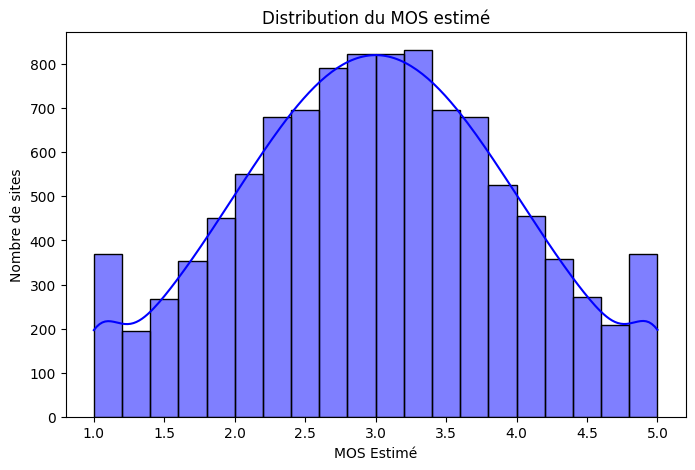

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["MOS Estimé"], bins=20, kde=True, color="blue")
plt.xlabel("MOS Estimé")
plt.ylabel("Nombre de sites")
plt.title("Distribution du MOS estimé")
plt.show()


Analyse des Corrélations entre les Métriques

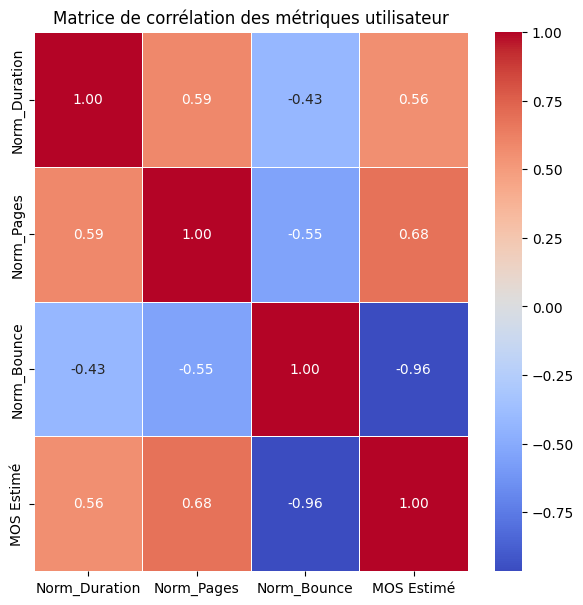

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rename columns to match the names used in the heatmap
numerical_df = df.rename(columns={
    'Avg. Visit Duration (s)': 'Norm_Duration',
    'Pages / Visit': 'Norm_Pages',
    'Bounce Rate (%)': 'Norm_Bounce'
})[['Norm_Duration', 'Norm_Pages', 'Norm_Bounce', 'MOS Estimé']]

plt.figure(figsize=(7, 7))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des métriques utilisateur")
plt.show()


Visualisation de la Distribution du MOS

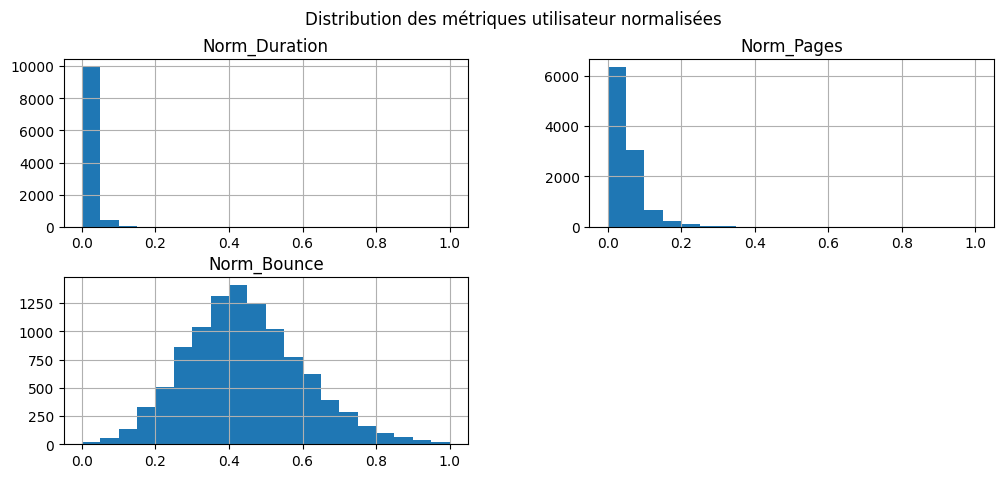

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use original column names or rename columns in the original DataFrame (df)
df = df.rename(columns={
    'Avg. Visit Duration (s)': 'Norm_Duration',
    'Pages / Visit': 'Norm_Pages',
    'Bounce Rate (%)': 'Norm_Bounce'
})

# Now you can use the renamed columns for the histogram
df[["Norm_Duration", "Norm_Pages", "Norm_Bounce"]].hist(figsize=(12, 5), bins=20)
plt.suptitle("Distribution des métriques utilisateur normalisées")
plt.show()

Distribution du MOS par Catégorie Principale

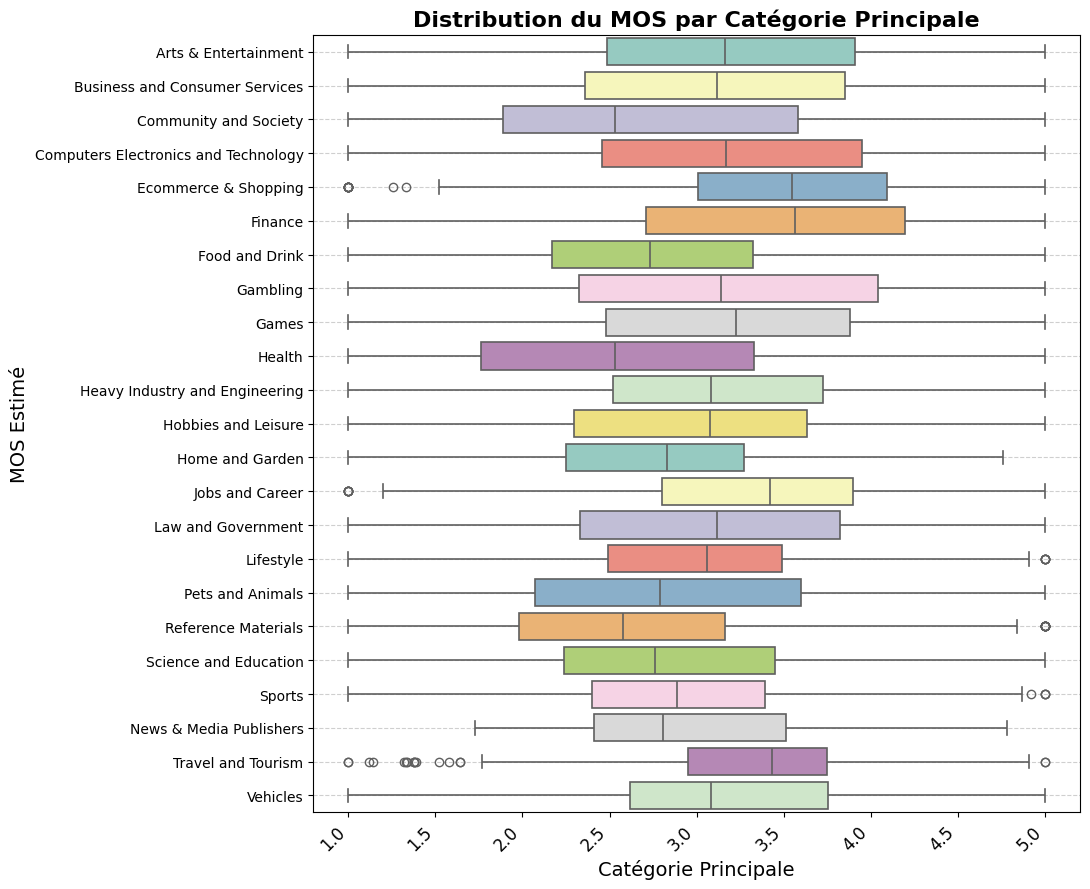

In [ ]:
plt.figure(figsize=(11, 9))
df['Top-Level Category'] = df['Category'].str.split(' > ').str[0]


sns.boxplot(x='MOS Estimé', y='Top-Level Category', hue='Top-Level Category', data=df, palette="Set3", linewidth=1.2, dodge=False)


plt.title("Distribution du MOS par Catégorie Principale", fontsize=16, weight='bold')
plt.xlabel('Catégorie Principale', fontsize=14)
plt.ylabel('MOS Estimé', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



Visualisation des relations entre les métriques normalisées et le MOS Estimé

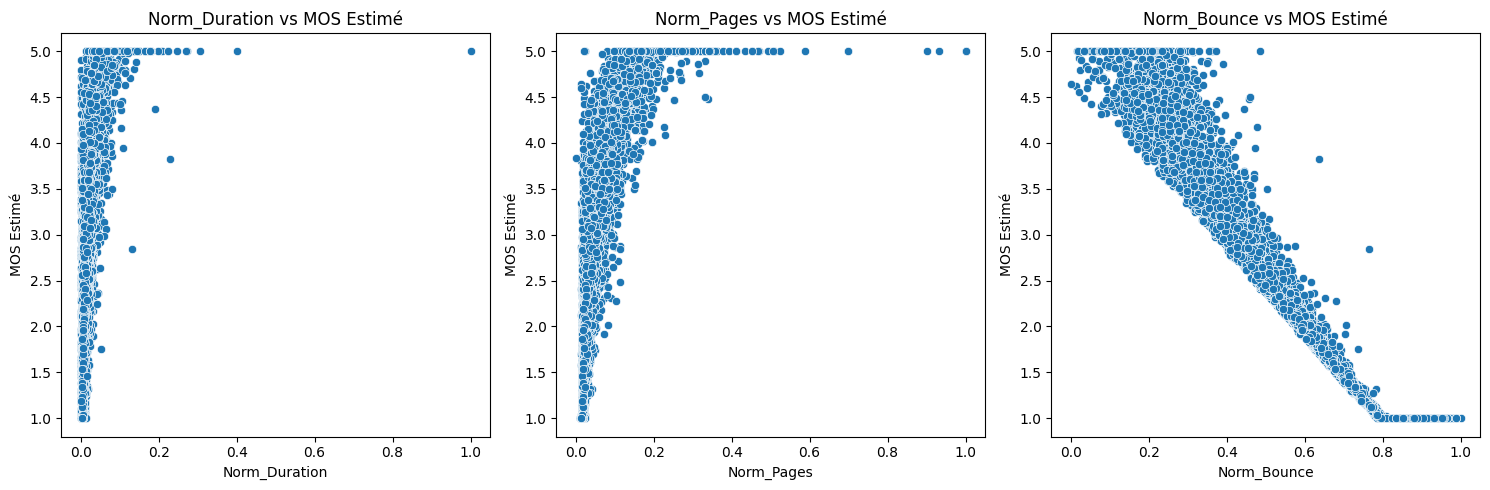

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=df["Norm_Duration"], y=df["MOS Estimé"], ax=axes[0])
axes[0].set_title("Norm_Duration vs MOS Estimé")

sns.scatterplot(x=df["Norm_Pages"], y=df["MOS Estimé"], ax=axes[1])
axes[1].set_title("Norm_Pages vs MOS Estimé")

sns.scatterplot(x=df["Norm_Bounce"], y=df["MOS Estimé"], ax=axes[2])
axes[2].set_title("Norm_Bounce vs MOS Estimé")

plt.tight_layout()
plt.show()


Visualisation de la relation entre la durée de la visite (en secondes) et le MOS estimé

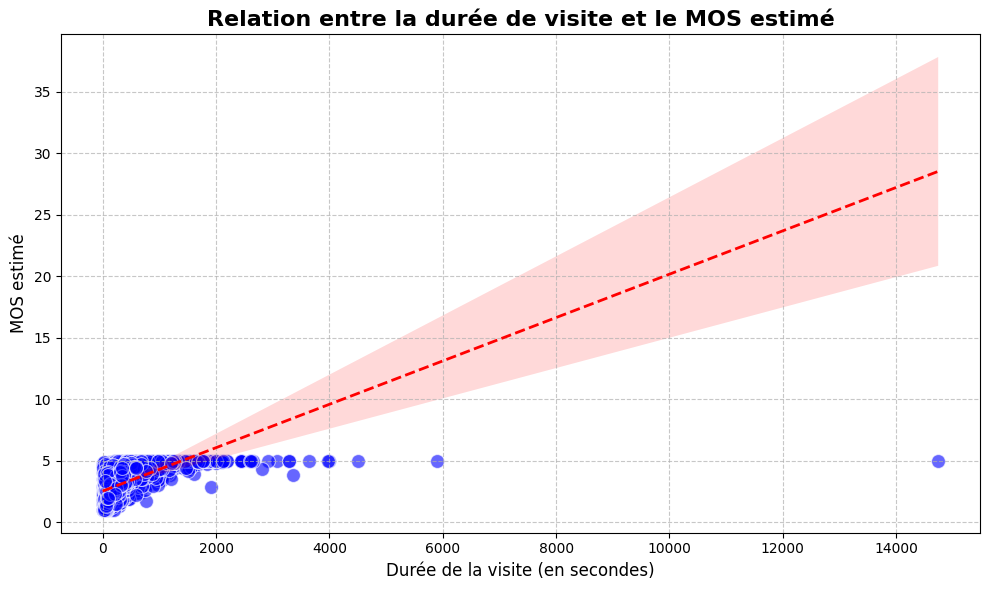

In [ ]:

df['Avg. Visit Duration (s)'] = pd.to_numeric(df['Avg. Visit Duration'].str.split(':').str[0]) * 3600 + \
                                 pd.to_numeric(df['Avg. Visit Duration'].str.split(':').str[1]) * 60 + \
                                 pd.to_numeric(df['Avg. Visit Duration'].str.split(':').str[2])


plt.figure(figsize=(10, 6))


sns.scatterplot(x=df['Avg. Visit Duration (s)'], y=df['MOS Estimé'], color='blue', s=100, alpha=0.6)


sns.regplot(x=df['Avg. Visit Duration (s)'], y=df['MOS Estimé'], scatter=False, color='red', line_kws={'linewidth': 2, 'linestyle': '--'})

plt.title("Relation entre la durée de visite et le MOS estimé", fontsize=16, fontweight='bold')
plt.xlabel("Durée de la visite (en secondes)", fontsize=12)
plt.ylabel("MOS estimé", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

Visualisation de la relation entre le nombre de pages par visite et le MOS estimé

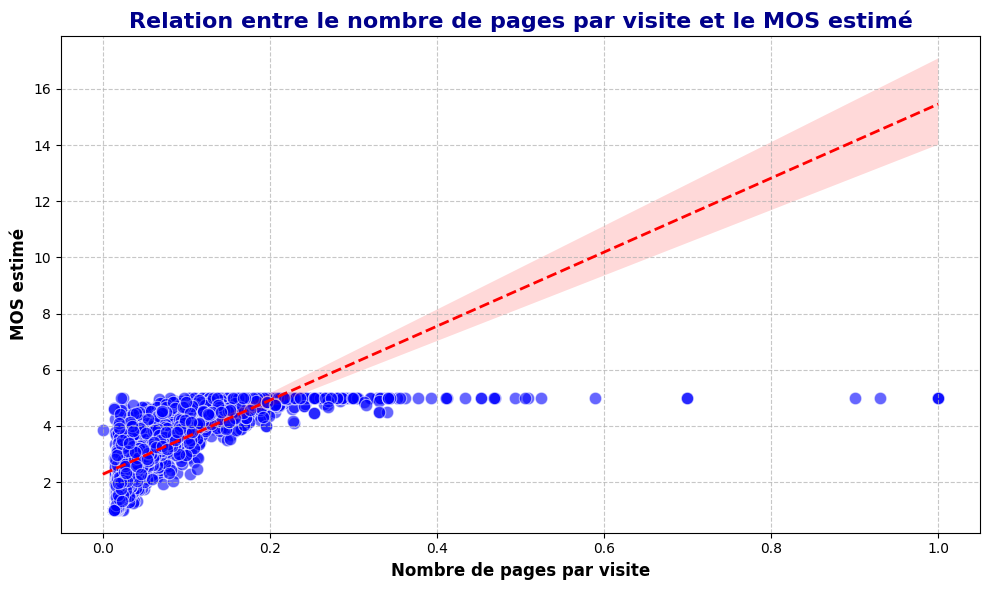

In [ ]:
# Rename columns to match the names used in the heatmap
numerical_df = df.rename(columns={
    'Avg. Visit Duration (s)': 'Norm_Duration',
    'Pages / Visit': 'Norm_Pages',
    'Bounce Rate (%)': 'Norm_Bounce'
})[['Norm_Duration', 'Norm_Pages', 'Norm_Bounce', 'MOS Estimé']]

# Access the column using its new name (Norm_Pages)
numerical_df['Norm_Pages'] = pd.to_numeric(numerical_df['Norm_Pages'], errors='coerce')
numerical_df['MOS Estimé'] = pd.to_numeric(numerical_df['MOS Estimé'], errors='coerce')

# ... (rest of your code using numerical_df instead of df for these specific operations) ...

plt.figure(figsize=(10, 6))

# Use the new name 'Norm_Pages' instead of 'Pages / Visit'
sns.scatterplot(x=numerical_df['Norm_Pages'], y=numerical_df['MOS Estimé'], color='blue', s=80, alpha=0.6)


sns.regplot(x=numerical_df['Norm_Pages'], y=numerical_df['MOS Estimé'], scatter=False, color='red',
            line_kws={'linewidth': 2, 'linestyle': '--'})


plt.title("Relation entre le nombre de pages par visite et le MOS estimé", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Nombre de pages par visite", fontsize=12, fontweight='bold')
plt.ylabel("MOS estimé", fontsize=12, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()

Visualisation de la relation entre le taux de rebond et le MOS estimé

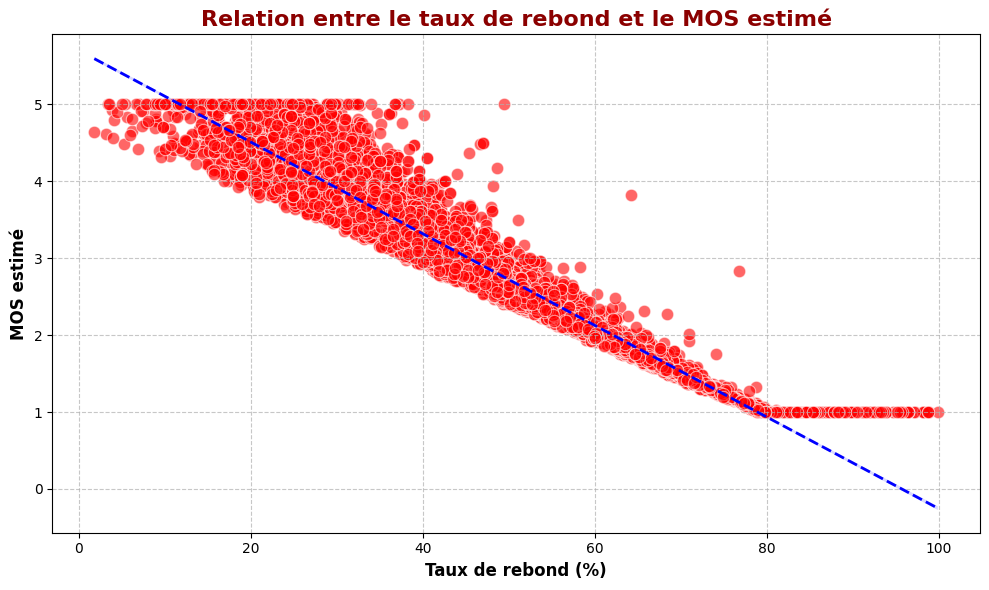

In [ ]:
df['Bounce Rate'] = df['Bounce Rate'].astype(str)
df['Bounce Rate'] = pd.to_numeric(df['Bounce Rate'].str.rstrip('%'), errors='coerce')
df['Bounce Rate'] = df['Bounce Rate'].fillna(df['Bounce Rate'].mean())
df['MOS Estimé'] = pd.to_numeric(df['MOS Estimé'], errors='coerce')
df['MOS Estimé'] = df['MOS Estimé'].fillna(df['MOS Estimé'].mean())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Bounce Rate'], y=df['MOS Estimé'], color='red', s=80, alpha=0.6)
sns.regplot(x=df['Bounce Rate'], y=df['MOS Estimé'], scatter=False, color='blue', line_kws={'linewidth': 2, 'linestyle': '--'})

plt.title("Relation entre le taux de rebond et le MOS estimé", fontsize=16, fontweight='bold', color='darkred')
plt.xlabel("Taux de rebond (%)", fontsize=12, fontweight='bold')
plt.ylabel("MOS estimé", fontsize=12, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


Modéle Autoencodeur + MLP

Epoch 1/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0242 - val_loss: 5.4980e-04
Epoch 2/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8155e-04 - val_loss: 3.1020e-04
Epoch 3/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7137e-04 - val_loss: 1.5939e-04
Epoch 4/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0312e-04 - val_loss: 1.0922e-04
Epoch 5/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.7761e-05 - val_loss: 9.2832e-05
Epoch 6/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.5788e-05 - val_loss: 8.5998e-05
Epoch 7/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5880e-05 - val_loss: 8.2593e-05
Epoch 8/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0753e-05 - val_loss: 1.0789e-04
Epoch 9/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4244e-05 - val_loss: 1.1868e-04
Epoch 10/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6691e-05 - val_loss: 8.0572e-05
Epoch 11/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

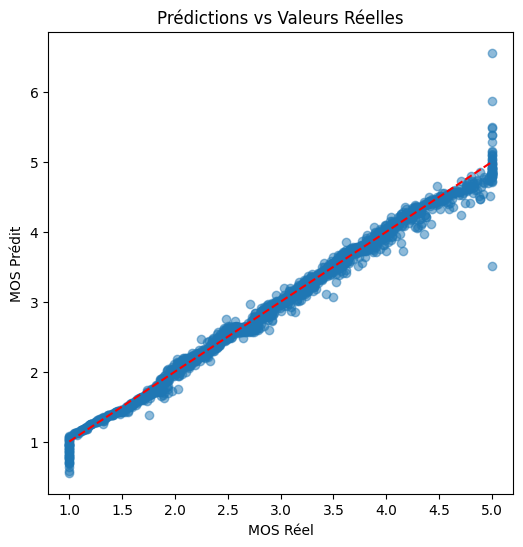

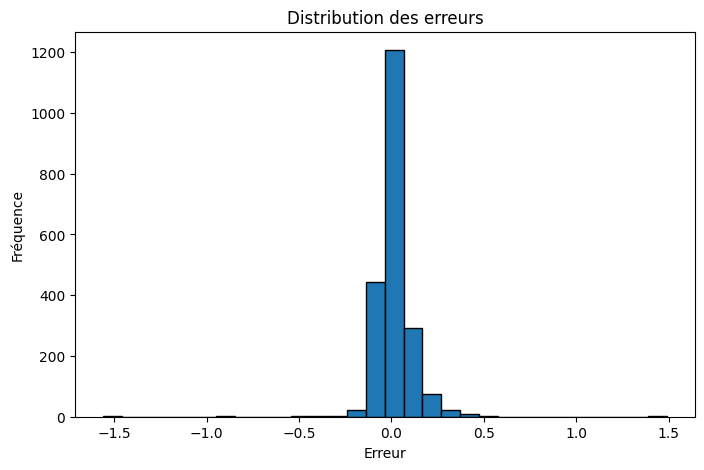

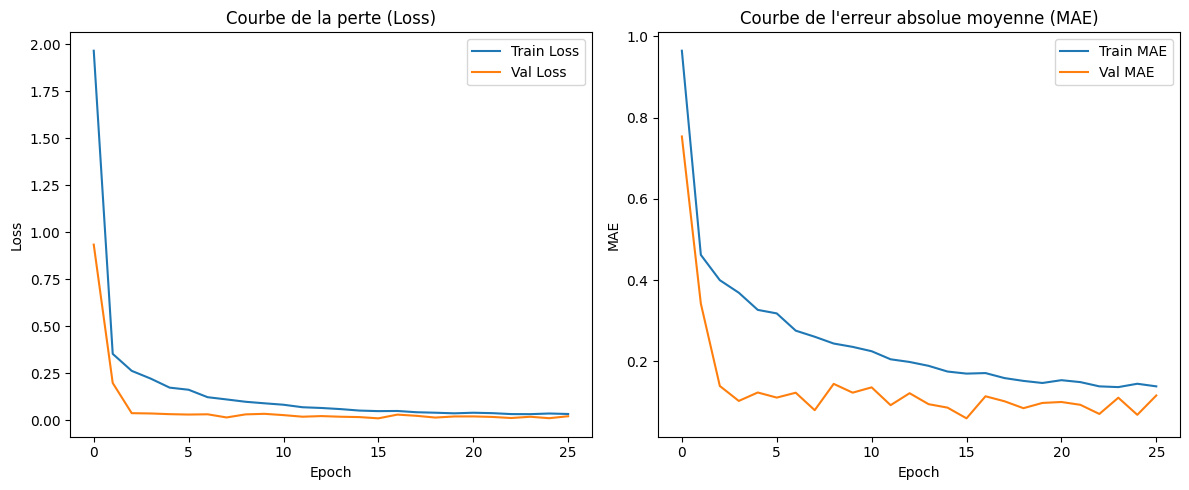

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Features and target definition
features = ["Avg. Visit Duration (s)", "Norm_Pages", "Norm_Bounce"]  # Assuming these are the correct column names
target = "MOS Estimé"

# Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df[target], test_size=0.2, random_state=42)

# ✅ 4. Construction de l'Autoencodeur
encoding_dim = 4  # augmenté pour mieux encoder

input_layer = keras.Input(shape=(X_train.shape[1],))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(X_train.shape[1], activation='linear')(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# EarlyStopping pour ne pas surentraîner
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement de l'autoencodeur
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=32,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping],
                verbose=1)

# Extraction des features encodés
encoder = keras.Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# ✅ 5. Construction du MLP
mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(encoding_dim,)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Compilation du modèle
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Entraînement du MLP
history = mlp_model.fit(
    X_train_encoded, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_encoded, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# ✅ 6. Évaluation
y_pred = mlp_model.predict(X_test_encoded)

# Calcul des erreurs
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# ✅ 7. Visualisations

# Scatter Plot Réel vs Prédit
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("MOS Réel")
plt.ylabel("MOS Prédit")
plt.title("Prédictions vs Valeurs Réelles")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.show()

# Histogramme des erreurs
errors = y_test - y_pred.flatten()
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Distribution des erreurs")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.show()

# Courbes de Loss et MAE
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de la perte (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Courbe de l'erreur absolue moyenne (MAE)")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Test du modéle Autoencodeur et MLP

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3229 - val_loss: 0.2730
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2658 - val_loss: 0.2003
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1813 - val_loss: 0.1324
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1226 - val_loss: 0.0821
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0757 - val_loss: 0.0583
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0547 - val_loss: 0.0480
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0435 - val_loss: 0.0403
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0377 - val_loss: 0.0348
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0327 - val_loss: 0.0297
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - val_loss: 0.0256
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260 - val_loss: 0.0219
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 - val

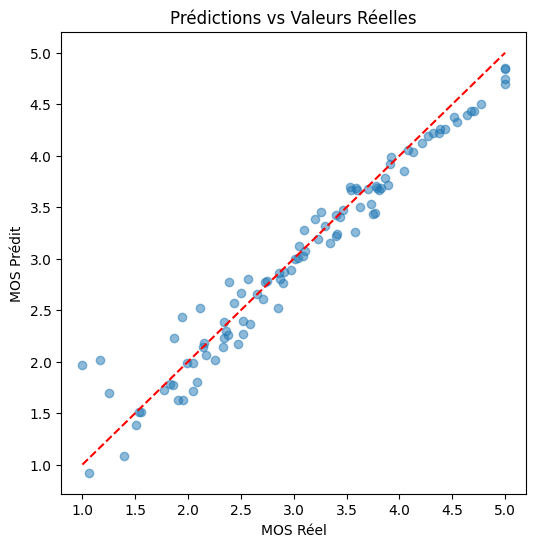

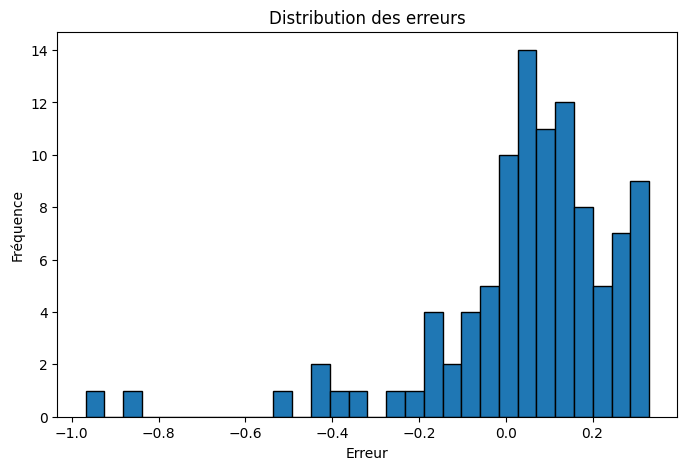

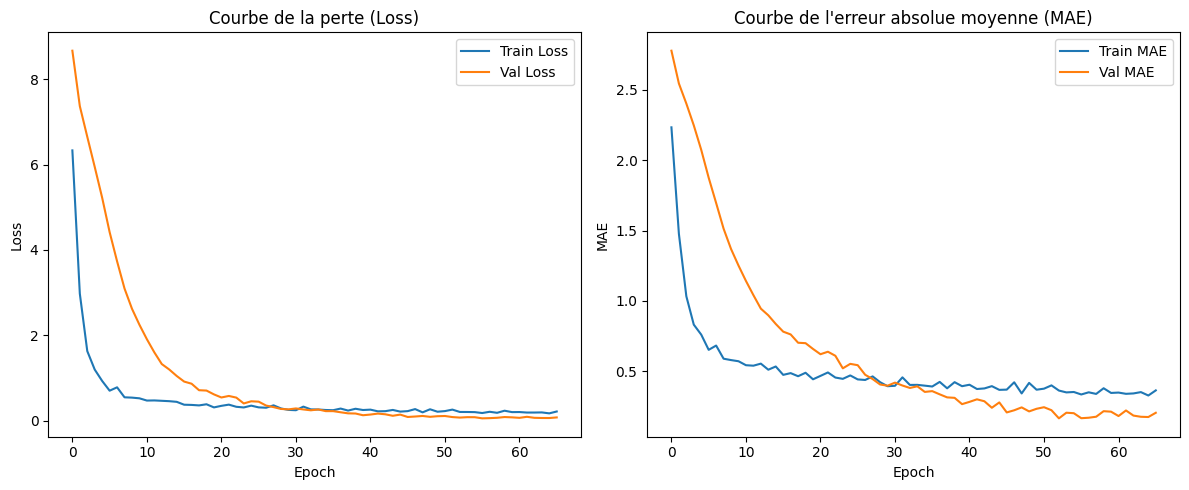

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras import layers

# ✅ 1. Génération de données synthétiques
def generate_synthetic_data(n_samples=500):
    np.random.seed(42)
    avg_visit_duration = np.random.randint(30, 900, size=n_samples)  # entre 30 sec et 15 min
    pages_per_visit = np.random.uniform(1, 10, size=n_samples)        # entre 1 et 10 pages
    bounce_rate = np.random.uniform(10, 80, size=n_samples)           # entre 10% et 80%

    df = pd.DataFrame({
        "Avg. Visit Duration (s)": avg_visit_duration,
        "Pages / Visit": pages_per_visit,
        "Bounce Rate (%)": bounce_rate
    })
    return df

df = generate_synthetic_data()

# ✅ 2. Calcul du MOS
def calculate_mos(df, duration_weight=0.4, pages_weight=0.3, bounce_weight=0.3):
    duration = np.log1p(df['Avg. Visit Duration (s)'])
    duration_score = (duration - duration.min()) / (duration.max() - duration.min())

    pages = np.log1p(df['Pages / Visit'])
    pages_score = (pages - pages.min()) / (pages.max() - pages.min())

    bounce_score = 1 - (df['Bounce Rate (%)'] / 100.0)

    weighted_score = (
        duration_weight * duration_score +
        pages_weight * pages_score +
        bounce_weight * bounce_score
    )

    percentile_ranks = weighted_score.rank(pct=True)
    z_scores = norm.ppf(percentile_ranks.clip(0.01, 0.99))
    scaled_scores = 3 + z_scores

    df['MOS Estimé'] = scaled_scores.clip(1, 5).round(2)

calculate_mos(df)

# ✅ 3. Features et target
features = ["Avg. Visit Duration (s)", "Pages / Visit", "Bounce Rate (%)"]
target = "MOS Estimé"

# Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df[target], test_size=0.2, random_state=42)

# ✅ 4. Construction de l'Autoencodeur
encoding_dim = 4  # augmenté pour mieux encoder

input_layer = keras.Input(shape=(X_train.shape[1],))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(X_train.shape[1], activation='linear')(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# EarlyStopping pour ne pas surentraîner
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement de l'autoencodeur
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping],
                verbose=1)

# Extraction des features encodés
encoder = keras.Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# ✅ 5. Construction du MLP
mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(encoding_dim,)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Compilation du modèle
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Entraînement du MLP
history = mlp_model.fit(
    X_train_encoded, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_encoded, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# ✅ 6. Évaluation
y_pred = mlp_model.predict(X_test_encoded)

# Calcul des erreurs
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# ✅ 7. Visualisations

# Scatter Plot Réel vs Prédit
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("MOS Réel")
plt.ylabel("MOS Prédit")
plt.title("Prédictions vs Valeurs Réelles")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.show()

# Histogramme des erreurs
errors = y_test - y_pred.flatten()
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Distribution des erreurs")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.show()

# Courbes de Loss et MAE
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de la perte (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Courbe de l'erreur absolue moyenne (MAE)")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Modéle TabNet


Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_1_mae = 0.0238

✅ Résultats sur le set de test :
MAE  : 0.1019
MSE  : 0.0210
RMSE : 0.1449
R²   : 0.9778
Explained Variance : 0.9800
Corrélation de Pearson : 0.9926


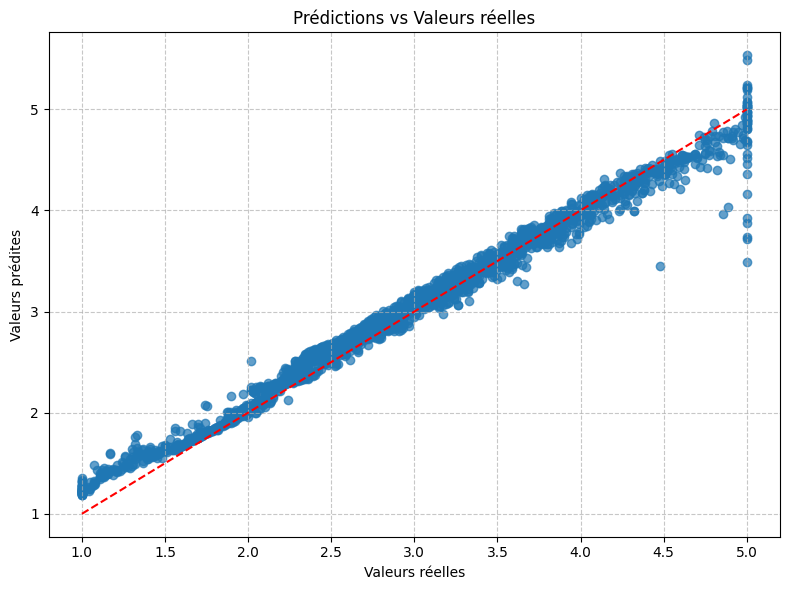

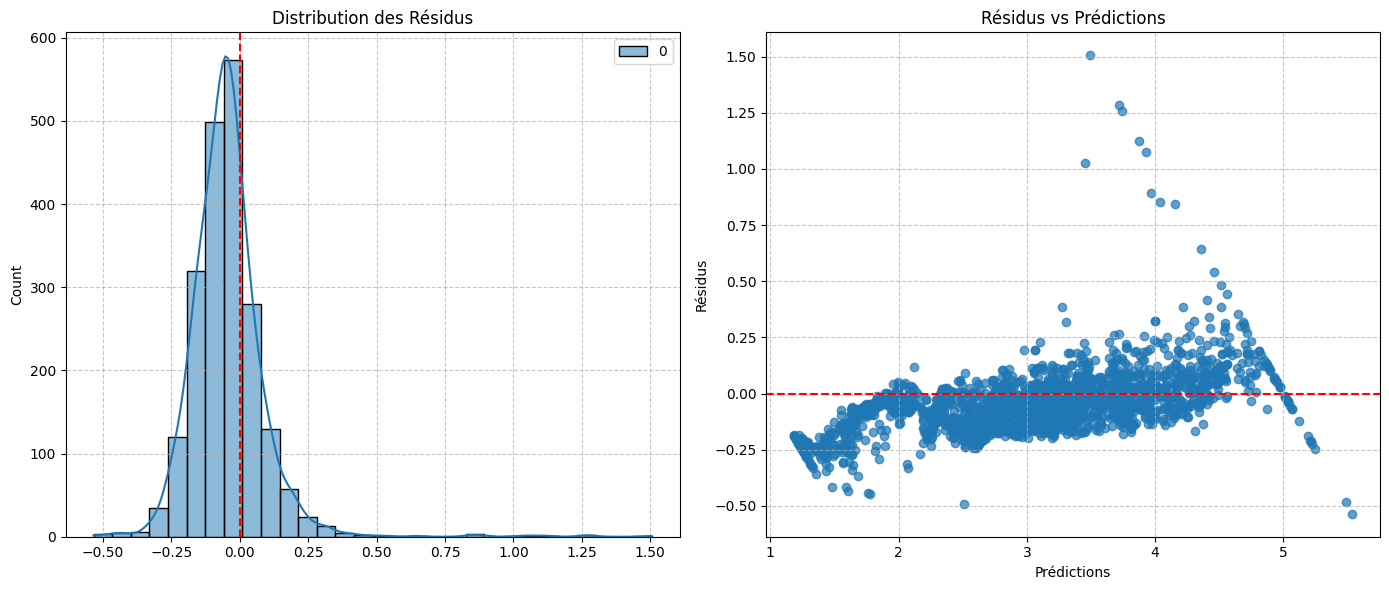

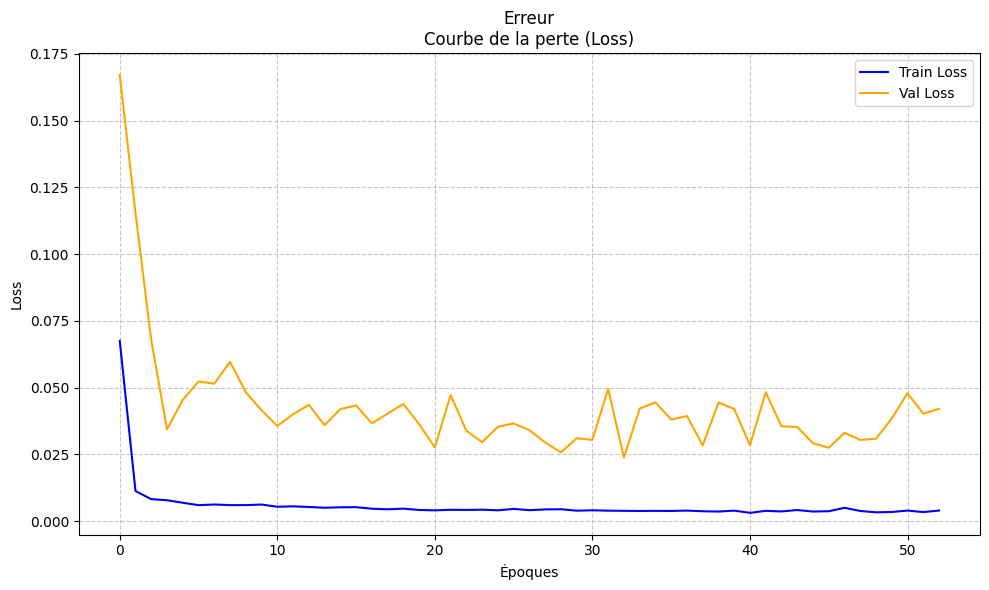


✅ Démarrage de la Validation Croisée...

Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_mae = 0.01857
Fold 1: MAE=0.0743, RMSE=0.1830, R²=0.9647

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_mae = 0.02214
Fold 2: MAE=0.0886, RMSE=0.1903, R²=0.9615

Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_mae = 0.01716
Fold 3: MAE=0.0687, RMSE=0.1225, R²=0.9833

Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_mae = 0.01632
Fold 4: MAE=0.0653, RMSE=0.1071, R²=0.9875

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mae = 0.01904
Fold 5: MAE=0.0762, RMSE=0.2365, R²=0.9376

✅ Moyennes Validation Croisée :
MAE  : 0.0746 ± 0.0080
RMSE : 0.1679 ± 0.0473
R²   : 0.9669 ± 0.0178


In [ ]:
# ✅ Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import warnings
warnings.filterwarnings('ignore')

# ✅ Features et Target
features = ["Avg. Visit Duration (s)", "Norm_Pages", "Bounce Rate"]
target = "MOS Estimé"

X = df[features]
y = df[target].values.reshape(-1, 1)

# ✅ Normalisation
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# ✅ Split train / validation / test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# ✅ Définition du modèle TabNet
tabnet = TabNetRegressor(
            n_d=6, n_a=6,
            n_steps=2,
            gamma=1.5,
            lambda_sparse=5e-4,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=5e-3),
            mask_type='sparsemax',
            verbose=0,
            device_name='auto'
        )

# ✅ Entraînement
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=['mae'],
    max_epochs=200,
    patience=20,
    batch_size=32,
    virtual_batch_size=16,
    num_workers=0,
    drop_last=False,
)

# ✅ Évaluation sur le test set
y_pred_scaled = tabnet.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# ✅ Métriques
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)
explained_var = explained_variance_score(y_test_original, y_pred)
pearson_corr, _ = pearsonr(y_test_original.flatten(), y_pred.flatten())

print(f"\n✅ Résultats sur le set de test :")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Explained Variance : {explained_var:.4f}")
print(f"Corrélation de Pearson : {pearson_corr:.4f}")

# ✅ Visualisation des prédictions
plt.figure(figsize=(8,6))
plt.scatter(y_test_original, y_pred, alpha=0.7)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédictions vs Valeurs réelles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ✅ Analyse des résidus
residuals = y_test_original - y_pred
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Distribution des Résidus')
plt.axvline(0, color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1,2,2)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Résidus vs Prédictions')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# ✅ Courbes d’apprentissage
plt.figure(figsize=(10, 6))
train_losses = tabnet.history['loss']
valid_losses = tabnet.history['val_1_mae']  # Vérifier si c’est 'val_0_mae' ou 'val_1_mae'

plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(valid_losses, label='Val Loss', color='orange')
plt.title('Erreur\nCourbe de la perte (Loss)')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Validation croisée (K-Fold)
def run_kfold_evaluation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mae_list, rmse_list, r2_list = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train_fold, X_val_fold = X[train_idx], X[test_idx]
        y_train_fold, y_val_fold = y[train_idx], y[test_idx]

        model = TabNetRegressor(
            n_d=6, n_a=6,
            n_steps=2,
            gamma=1.5,
            lambda_sparse=5e-4,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=5e-3),
            mask_type='sparsemax',
            verbose=0,
            device_name='auto'
        )

        model.fit(
            X_train=X_train_fold, y_train=y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=['mae'],
            max_epochs=200,
            patience=10,
            batch_size=64,
            virtual_batch_size=32,
            num_workers=0,
            drop_last=False
        )

        y_val_pred_scaled = model.predict(X_val_fold)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
        y_val_original = scaler_y.inverse_transform(y_val_fold)

        fold_mae = mean_absolute_error(y_val_original, y_val_pred)
        fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred))
        fold_r2 = r2_score(y_val_original, y_val_pred)

        print(f"Fold {fold}: MAE={fold_mae:.4f}, RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")
        mae_list.append(fold_mae)
        rmse_list.append(fold_rmse)
        r2_list.append(fold_r2)

    print("\n✅ Moyennes Validation Croisée :")
    print(f"MAE  : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
    print(f"RMSE : {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
    print(f"R²   : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# ✅ Lancer la validation croisée
print("\n✅ Démarrage de la Validation Croisée...")
run_kfold_evaluation(X_scaled, y_scaled, n_splits=5)


test du modéle TabNet

epoch 0  | loss: 8.3454  | val_0_mae: 1.42196 |  0:00:00s
epoch 10 | loss: 0.02734 | val_0_mae: 0.19378 |  0:00:02s
epoch 20 | loss: 0.01316 | val_0_mae: 0.13403 |  0:00:04s
epoch 30 | loss: 0.01498 | val_0_mae: 0.11412 |  0:00:07s
epoch 40 | loss: 0.00959 | val_0_mae: 0.08345 |  0:00:09s
epoch 50 | loss: 0.00841 | val_0_mae: 0.07817 |  0:00:11s
epoch 60 | loss: 0.00759 | val_0_mae: 0.0722  |  0:00:13s
epoch 70 | loss: 0.00706 | val_0_mae: 0.05054 |  0:00:14s
epoch 80 | loss: 0.00403 | val_0_mae: 0.04608 |  0:00:17s
epoch 90 | loss: 0.00634 | val_0_mae: 0.04981 |  0:00:19s
epoch 100| loss: 0.00407 | val_0_mae: 0.03169 |  0:00:21s

Early stopping occurred at epoch 105 with best_epoch = 95 and best_val_0_mae = 0.02679

✅ Résultats sur le set de test :
MAE  : 0.1253
MSE  : 0.0330
RMSE : 0.1816
R²   : 0.9673
Explained Variance : 0.9680
Corrélation de Pearson : 0.9860


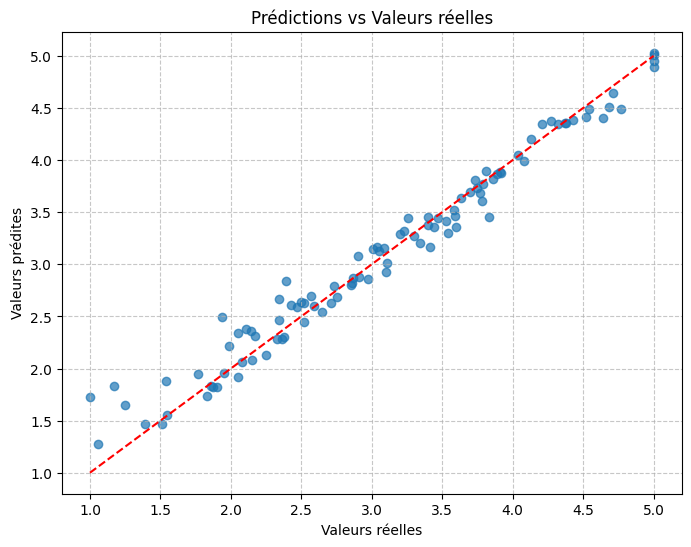

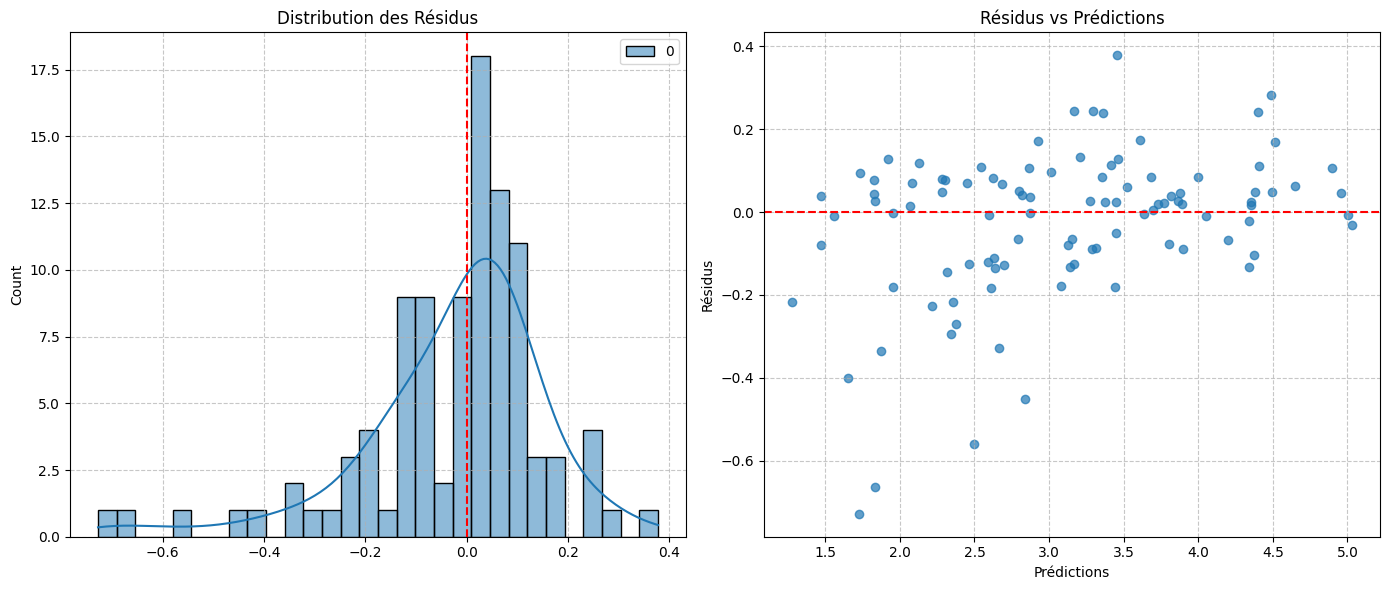


✅ Démarrage de la Validation Croisée...

Early stopping occurred at epoch 79 with best_epoch = 69 and best_val_0_mae = 0.0315
Fold 1: MAE=0.1260, RMSE=0.1923, R²=0.9634

Early stopping occurred at epoch 78 with best_epoch = 68 and best_val_0_mae = 0.02433
Fold 2: MAE=0.0973, RMSE=0.1344, R²=0.9791

Early stopping occurred at epoch 99 with best_epoch = 89 and best_val_0_mae = 0.02619
Fold 3: MAE=0.1048, RMSE=0.1609, R²=0.9712

Early stopping occurred at epoch 87 with best_epoch = 77 and best_val_0_mae = 0.02212
Fold 4: MAE=0.0885, RMSE=0.1262, R²=0.9809

Early stopping occurred at epoch 66 with best_epoch = 56 and best_val_0_mae = 0.02999
Fold 5: MAE=0.1200, RMSE=0.1636, R²=0.9727

✅ Moyennes Validation Croisée :
MAE  : 0.1073 ± 0.0139
RMSE : 0.1555 ± 0.0235
R²   : 0.9735 ± 0.0062


In [ ]:
# ✅ Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import warnings
warnings.filterwarnings('ignore')

# ✅ Génération de données synthétiques
def generate_synthetic_data(n_samples=500):
    np.random.seed(42)

    avg_visit_duration = np.random.randint(30, 900, size=n_samples)  # entre 30 sec et 15 min
    pages_per_visit = np.random.uniform(1, 10, size=n_samples)       # entre 1 et 10 pages
    bounce_rate = np.random.uniform(10, 80, size=n_samples)          # entre 10% et 80%

    df = pd.DataFrame({
        "Avg. Visit Duration (s)": avg_visit_duration,
        "Pages / Visit": pages_per_visit,
        "Bounce Rate (%)": bounce_rate
    })
    return df

df = generate_synthetic_data()

# ✅ Fonction pour calculer le MOS
def calculate_mos(df, duration_weight=0.4, pages_weight=0.3, bounce_weight=0.3):
    duration = np.log1p(df['Avg. Visit Duration (s)'])
    duration_score = (duration - duration.min()) / (duration.max() - duration.min())

    pages = np.log1p(df['Pages / Visit'])
    pages_score = (pages - pages.min()) / (pages.max() - pages.min())

    bounce_score = 1 - (df['Bounce Rate (%)'] / 100.0)

    weighted_score = (
        duration_weight * duration_score +
        pages_weight * pages_score +
        bounce_weight * bounce_score
    )

    percentile_ranks = weighted_score.rank(pct=True)
    z_scores = norm.ppf(percentile_ranks.clip(0.01, 0.99))
    scaled_scores = 3 + z_scores

    df['MOS Estimé'] = scaled_scores.clip(1, 5).round(2)

calculate_mos(df)

# ✅ Features et Target
features = ["Avg. Visit Duration (s)", "Pages / Visit", "Bounce Rate (%)"]
target = "MOS Estimé"

X = df[features]
y = df[target].values.reshape(-1, 1)

# ✅ Normalisation
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# ✅ Split train / validation / test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# ✅ TabNet Model (modifié)
tabnet = TabNetRegressor(
    n_d=16, n_a=16,
    n_steps=5,
    gamma=1.3,  # 🔥 Gamma réduit pour plus de flexibilité
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax',  # 🔥 Changement de mask_type pour essayer plus rapide
    verbose=10,
    device_name='auto'
)

# ✅ Entraînement (modifié patience=10)
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['mae'],
    max_epochs=200,
    patience=10,  # 🔥 Early Stopping plus rapide
    batch_size=64,
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

# ✅ Évaluation sur Test Set
y_pred_scaled = tabnet.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)
explained_var = explained_variance_score(y_test_original, y_pred)
pearson_corr, _ = pearsonr(y_test_original.flatten(), y_pred.flatten())

print(f"\n✅ Résultats sur le set de test :")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Explained Variance : {explained_var:.4f}")
print(f"Corrélation de Pearson : {pearson_corr:.4f}")

# ✅ Visualisation: Réel vs Prédit
plt.figure(figsize=(8,6))
plt.scatter(y_test_original, y_pred, alpha=0.7)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédictions vs Valeurs réelles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ✅ Analyse des Résidus
residuals = y_test_original - y_pred
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Distribution des Résidus')
plt.axvline(0, color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1,2,2)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Résidus vs Prédictions')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# ✅ Validation Croisée (K-Fold) (modifié)
def run_kfold_evaluation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mae_list, rmse_list, r2_list = [], [], []
    fold = 1

    for train_idx, test_idx in kf.split(X):
        X_train_fold, X_val_fold = X[train_idx], X[test_idx]
        y_train_fold, y_val_fold = y[train_idx], y[test_idx]

        model = TabNetRegressor(
            n_d=16, n_a=16,
            n_steps=5,
            gamma=1.3,  # 🔥 Gamma réduit
            lambda_sparse=1e-4,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-2),
            mask_type='sparsemax',  # 🔥 mask_type changé
            verbose=0,
            device_name='auto'
        )

        model.fit(
            X_train=X_train_fold, y_train=y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=['mae'],
            max_epochs=200,
            patience=10,  # 🔥 Early stopping plus rapide
            batch_size=64,
            virtual_batch_size=32,
            num_workers=0,
            drop_last=False
        )

        y_val_pred_scaled = model.predict(X_val_fold)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
        y_val_original = scaler_y.inverse_transform(y_val_fold)

        fold_mae = mean_absolute_error(y_val_original, y_val_pred)
        fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred))
        fold_r2 = r2_score(y_val_original, y_val_pred)

        print(f"Fold {fold}: MAE={fold_mae:.4f}, RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")

        mae_list.append(fold_mae)
        rmse_list.append(fold_rmse)
        r2_list.append(fold_r2)
        fold += 1

    print("\n✅ Moyennes Validation Croisée :")
    print(f"MAE  : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
    print(f"RMSE : {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
    print(f"R²   : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

print("\n✅ Démarrage de la Validation Croisée...")
run_kfold_evaluation(X_scaled, y_scaled, n_splits=5)


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.0025 - mean_absolute_error: 0.6998 - val_loss: 0.0758 - val_mean_absolute_error: 0.1106 - learning_rate: 0.0010
Epoch 2/300
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2117 - mean_absolute_error: 0.2825 - val_loss: 0.0547 - val_mean_absolute_error: 0.0564 - learning_rate: 0.0010
Epoch 3/300
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1239 - mean_absolute_error: 0.1960 - val_loss: 0.0478 - val_mean_absolute_error: 0.0341 - learning_rate: 0.0010
Epoch 4/300
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0913 - mean_absolute_error: 0.1545 - val_loss: 0.0442 - val_mean_absolute_error: 0.0367 - learning_rate: 0.0010
Epoch 5/300
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0696 - mean_absolute_error: 0.1247 - val_loss: 0.0406 - val_mean_absolute_error: 0.0287 - learning_rate: 0.0010
Epoch 6/300
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0580 - mean_absolute_error: 0.1048 - val_loss: 0.0376 - val_mean_absolute_

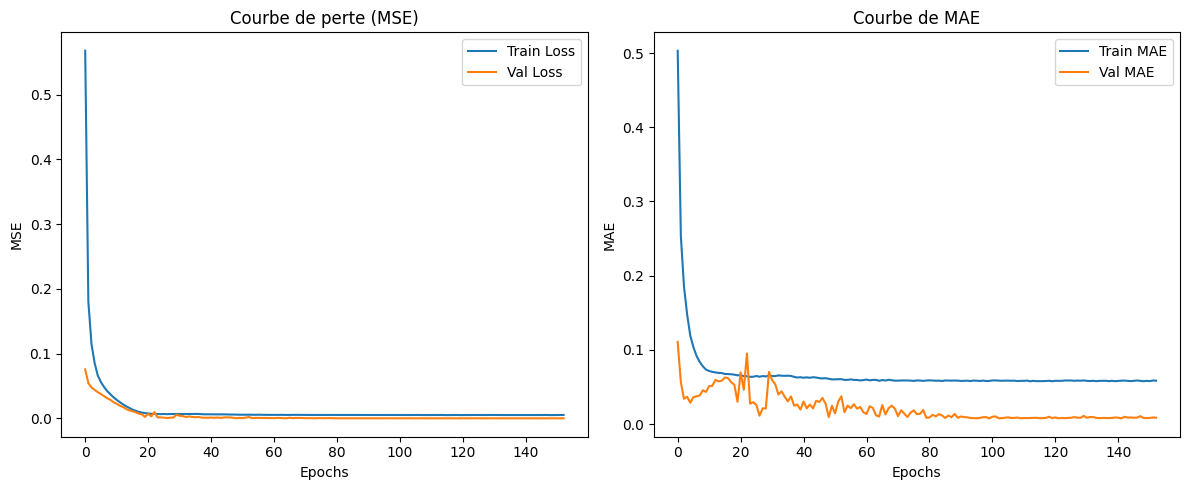

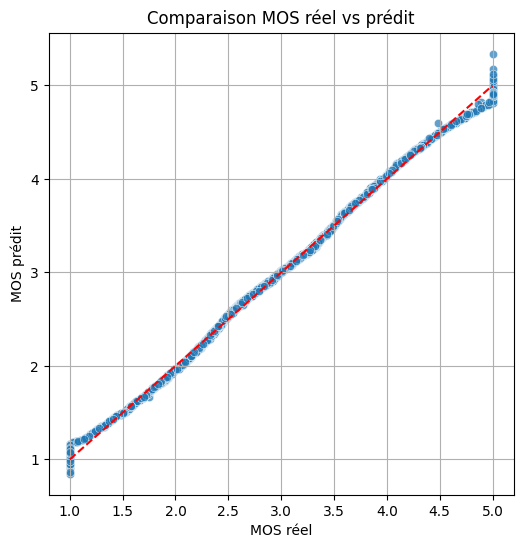

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Exemple de chargement des données (à adapter)
# df = pd.read_csv('data.csv')

# ✅ Sélection des Features et de la Target
features = ["Avg. Visit Duration (s)", "Norm_Pages", "Bounce Rate"]
target = "MOS Estimé"

X = df[features]
y = df[target].values.reshape(-1, 1)

# ✅ Normalisation
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# ✅ Construction du modèle
def build_deep_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# ✅ Entraînement du modèle
def train_model(X, y, epochs=300, batch_size=16):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_deep_model(X_train.shape[1])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Évaluation
    y_pred = model.predict(X_test).flatten()
    y_test_flat = y_test.flatten()

    # Inverse transform pour retrouver les vraies valeurs si besoin :
    y_test_inv = scaler_y.inverse_transform(y_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    mar = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100  # MAR en %

    print(f"\n✅ Résultats sur test set :")
    print(f" - MSE : {mse:.4f}")
    print(f" - MAE : {mae:.4f}")
    print(f" - R²  : {r2:.4f}")
    print(f" - MAR : {mar:.2f}%")

    return model, history, X_test, y_test, y_pred, y_test_inv, y_pred_inv

# ✅ Entraînement final
model, history, X_test, y_test, y_pred, y_test_inv, y_pred_inv = train_model(X_scaled, y_scaled)

# ✅ Visualisation des performances
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de perte (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.title("Courbe de MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Comparaison graphique des prédictions
# ✅ Comparaison graphique des prédictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred_inv, alpha=0.7) # flatten y_test_inv
plt.xlabel("MOS réel")
plt.ylabel("MOS prédit")
plt.title("Comparaison MOS réel vs prédit")
plt.plot([min(y_test_inv), max(y_test_inv)],
         [min(y_test_inv), max(y_test_inv)], color='red', linestyle='--')
plt.grid(True)
plt.show()

